## CASE ONE: CARTPOLE with BINS : tabular method

In [1]:
# 1.reality:
#   some angle are impossible
#   large velocity is highly unlikely
# 2.cut up relevant part of state space into boxes: tabular method
# Q: how to choose box size, what if lie out of scope(can extend one bx to inf)
# default reward: +1 for every step
# fall: -300

In [2]:
import gym
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime

#### 1. generate tabular

In [3]:
def generate_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

In [4]:
def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]

In [5]:
class FeatureTransformer(object):
    def __init__(self):
        self.cart_position_bins = np.linspace(-2.4, 2.4, 9)
        self.cart_velocity_bins = np.linspace(-2, 2, 9) # (-inf, inf)
        self.pole_angle_bins = np.linspace(-0.4, 0.4, 9)
        self.pole_velocity_bins = np.linspace(-3.5, 3.5, 9) # (-inf, inf) 

    def transform(self, observation):
        # returns an int
        cart_pos, cart_vel, pole_angle, pole_vel = observation
        return generate_state([
          to_bin(cart_pos, self.cart_position_bins),
          to_bin(cart_vel, self.cart_velocity_bins),
          to_bin(pole_angle, self.pole_angle_bins),
          to_bin(pole_vel, self.pole_velocity_bins),
        ])

#### 2. Agent

In [6]:
class Agent(object):
    def __init__(self, env, feature_transformer):
        self.env = env
        self.feature_transformer = feature_transformer

        num_states = 10**env.observation_space.shape[0]
        num_actions = env.action_space.n
        self.Q = np.random.uniform(low=-1, high=1, size=(num_states, num_actions))

    def predict(self, s):
        x = self.feature_transformer.transform(s)
        return self.Q[x]

    def update(self, s, a, G):
        x = self.feature_transformer.transform(s)
        self.Q[x,a] += 1e-2*(G - self.Q[x,a])

    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            p = self.predict(s)
            return np.argmax(p)  

#### 3.one episode

In [7]:
def play_one(agent, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    while not done and iters < 10000:
        action = agent.sample_action(observation, eps) # sample_action: epsilon greedy 
        prev_observation = observation
        observation, reward, done, info = env.step(action)

        totalreward += reward

        if done and iters < 199:
            reward = -300

        # update the model
        G = reward + gamma*np.max(agent.predict(observation))
        agent.update(prev_observation, action, G)

        iters += 1

    return totalreward

#### 4. plot average

In [8]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

#### 5. main loop

episode: 0 total reward: 16.0 eps: 1.0
episode: 100 total reward: 76.0 eps: 0.099503719021
episode: 200 total reward: 50.0 eps: 0.0705345615859
episode: 300 total reward: 54.0 eps: 0.0576390417704
episode: 400 total reward: 10.0 eps: 0.0499376169439
episode: 500 total reward: 114.0 eps: 0.0446767051609
episode: 600 total reward: 200.0 eps: 0.0407908508224
episode: 700 total reward: 46.0 eps: 0.03776947873
episode: 800 total reward: 31.0 eps: 0.0353332626669
episode: 900 total reward: 43.0 eps: 0.0333148302326
episode: 1000 total reward: 60.0 eps: 0.0316069770621
episode: 1100 total reward: 10.0 eps: 0.0301374387339
episode: 1200 total reward: 37.0 eps: 0.0288554928412
episode: 1300 total reward: 49.0 eps: 0.0277243486501
episode: 1400 total reward: 76.0 eps: 0.0267165842573
episode: 1500 total reward: 33.0 eps: 0.025811286646
episode: 1600 total reward: 132.0 eps: 0.0249921911602
episode: 1700 total reward: 51.0 eps: 0.0242464322484
episode: 1800 total reward: 172.0 eps: 0.023563681481

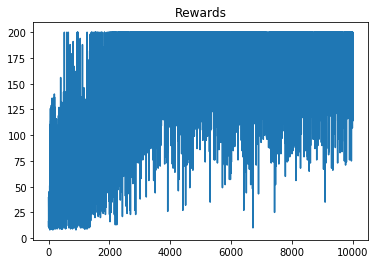

In [9]:
env = gym.make('CartPole-v0')
featuretransformer = FeatureTransformer()
agent = Agent(env, featuretransformer)
gamma = 0.9

if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)

N = 10000
totalrewards = np.empty(N)
for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(agent, eps, gamma)
    totalrewards[n] = totalreward
    if n % 100 == 0:
        print("episode:", n, "total reward:", totalreward, "eps:", eps)
print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

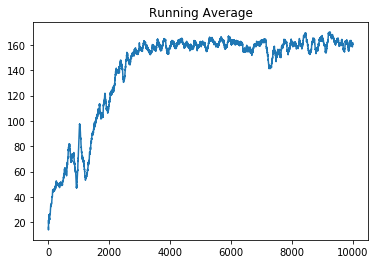

In [10]:
plot_running_avg(totalrewards)